In [74]:
from pyecharts import options as opts
from pyecharts.charts import Line, Timeline, Bar, Scatter, WordCloud
from pyecharts.commons.utils import JsCode
from pyecharts.globals import SymbolType
import pandas as pd
import numpy as np
import jieba
import re
import seaborn as sns
from matplotlib import pyplot as plt
# 设置绘图字体为黑体
plt.rcParams['font.sans-serif'] = ['SimHei']

In [75]:
# 清洗后的数据
cleaned_data_path = r'tap_reviews-extend cleaned.csv'

In [76]:
# 加载数据
data = pd.read_csv(cleaned_data_path, encoding='utf_8_sig')

In [77]:
# 预览数据
data.head(10)

,id,author,updated_time,device,spent,stars,contents,net_support,heat,score
0,24420387,神奇而小伟21,2021-04-28,OPPO A8,81762.0,2,个人感觉还好就是不优化健康系统我一个19岁的学生被弟绑了他的身份证一天只能玩1.5个小时给客...,1,0.001036,4
1,24420357,手机用户101721273,2021-04-28,华为畅享9 Plus,NaN,3,快12G了，不知道为啥这么占内存,0,0.000000,6
2,18626820,天人,2021-04-28,小米Redmi K30 Pro,17518.0,1,说白了这游戏，根本是游戏在玩你，不是你在玩游戏给一星都恶心，皮肤你tm出的快，你阿妈那鸡粪匹...,5,0.005181,2
3,24420027,子旭,2021-04-28,华为P20,120001.0,1,这游戏巨好玩，好玩在哪呢他可以通地府让你跟阴间的人一起玩，真的赶紧下载吧一起成为捉鬼师⊙⊙,0,0.000000,2
4,22146899,宇智波x人妖王,2021-04-28,小米MI MAX 2,78210.0,3,啊退坑了 渐渐的周围的人也不玩王者了 一个人坚持不下去了 无数次的下载 可能有30多次安装...,1,0.003109,6
5,24419822,迟到的誓言,2021-04-28,Vivo IQOO Neo3,61696.0,3,这游戏玩了8000多吧，现在出来工作了，就不是很想玩了,0,0.000000,6
6,24419348,Devil丶May丶Cry,2021-04-28,华为P40,NaN,1,垃圾游戏，废物游戏，辣鸡匹配系统，不想让赢直说，直接网络波动，真有你的，垃圾腾讯，废物腾讯。,0,0.000000,2
7,24419100,蒋佳恩,2021-04-27,华为NOP-AN00,7499.0,5,玩游戏，最重要的就是开心嘛！和朋友一起玩很开心。因为王者我都快心悦2了,0,0.000000,10
8,24418917,jsjjx,2021-04-27,NaN,NaN,4,还行吧，毕竟是游戏嘛，以娱乐为主,0,0.000000,8
9,24418745,似馀,2021-04-27,华为畅享9 Plus,90910.0,2,游戏优化太差了，elo机制很难连胜，有时网是好的却也很卡,1,0.001036,4


### 一.查看数据分布情况

一定程度上反映玩家对游戏的整体满意度

D:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


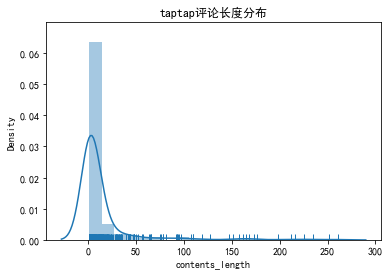

评论长度的9/10分位数： 193.0


In [78]:
# 查看评论长度分布
data['contents_length'] = data['contents'].apply(lambda x: len(str(x)))
len_se = data.groupby('contents_length')['contents_length'].count()
sns.distplot(len_se, bins=20, hist=True, kde=True, rug=True)
plt.title('taptap评论长度分布')
plt.show()
print('评论长度的9/10分位数：', data['contents_length'].quantile(0.9))

D:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


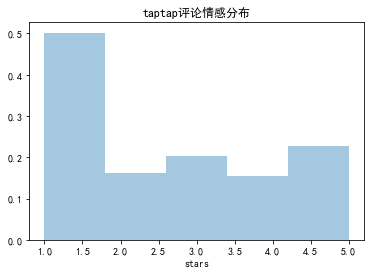

正面评价: 2468，占总数的30.62%    负面评价: 5592, 占总数的69.38%


In [79]:
# 查看评论情感分布，4星及其以上表示正面评价
positive = len(data['stars'][data['stars'] >= 4])
total = len(data['stars'])
negative = total - positive
sns.distplot(data['stars'], bins=5, kde=False, norm_hist=True)
plt.title('taptap评论情感分布')
plt.show()
print('正面评价: %d，占总数的%.2f%%    负面评价: %d, 占总数的%.2f%%' %
      (positive, (positive/total*100), negative, (negative/total*100)))

### 2.玩家评分变化趋势

一定程度上反映玩家活跃度变化和对版本的满意度

In [80]:
# 数据透视表，对日期聚合，计算每日评分的均值、频次
table = pd.pivot_table(data, index=['updated_time'], values=['score'], aggfunc=['mean', 'count'])
# 对表头文本进行替换
table.columns = ['score_mean', 'score_count']
# 均值保留两位小数
table['score_mean'] = np.round(table['score_mean'], 2)
# 将index转换为DatetimeIndex格式，方便后面画图
table.index = pd.DatetimeIndex(table.index)

In [81]:
# 查看聚合后的数据透析表
table

,score_mean,score_count
updated_time,,
2021-02-16,5.00,239
2021-02-17,5.14,285
2021-02-18,5.04,295
2021-02-19,5.37,255
2021-02-20,5.05,239
...,...,...
2021-04-24,5.18,85
2021-04-25,4.79,81
2021-04-26,4.50,111


In [82]:
# 评分均值折线图
line_demo = (
    Line(init_opts=opts.InitOpts(theme='dark'))
    .add_xaxis(table.index)
    .add_yaxis('玩家评分', table['score_mean'], is_smooth=True, areastyle_opts=opts.AreaStyleOpts(
            color=JsCode(area_color_js), opacity=1), markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(
            type_='average')], linestyle_opts=opts.LineStyleOpts(color='white', type_='dashed')))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False), markpoint_opts=opts.MarkPointOpts(
            data=[opts.MarkPointItem(type_='max', name='最高分'), opts.MarkPointItem(type_='min', name='最低分')]))
    .set_global_opts(title_opts=opts.TitleOpts(title='taptap评分均值变化趋势', subtitle='2021-02-26 至 2021-04-28 ',
            title_textstyle_opts=opts.TextStyleOpts(
            color="#fff", font_size=16)), xaxis_opts=opts.AxisOpts(type_='time'), yaxis_opts=opts.AxisOpts(
            type_='value', min_=8), tooltip_opts=opts.TooltipOpts(trigger='axis', axis_pointer_type='cross'))
)
line_demo.render_notebook()

In [83]:
# 评分频率折线图
line_demo = (
    Line(init_opts=opts.InitOpts(theme='dark'))
    .add_xaxis(table.index)
    .add_yaxis('玩家评分', table['score_count'], is_smooth=True, areastyle_opts=opts.AreaStyleOpts(
            color=JsCode(area_color_js), opacity=1), markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(
            type_='average')], linestyle_opts=opts.LineStyleOpts(color='white', type_='dashed')))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False), markpoint_opts=opts.MarkPointOpts(
            data=[opts.MarkPointItem(type_='max', name='最高分'), opts.MarkPointItem(type_='min', name='最低分')]))
    .set_global_opts(title_opts=opts.TitleOpts(title='taptap每日评分频率变化趋势', subtitle='2021-02-26 至 2021-04-28 ',
            title_textstyle_opts=opts.TextStyleOpts(
            color="#fff", font_size=16)), xaxis_opts=opts.AxisOpts(type_='time'), yaxis_opts=opts.AxisOpts(
            type_='value', min_=8), tooltip_opts=opts.TooltipOpts(trigger='axis', axis_pointer_type='cross'))
)
line_demo.render_notebook()

In [84]:
# 评分趋势折线
data_type = {'评分均值': 'score_mean', '评分频率': 'score_count'}
area_color_js = (
    "new echarts.graphic.LinearGradient(0, 0, 0, 1, "
    "[{offset: 0, color: '#db5856'}, {offset: 1, color: '#0b8b87'}], false)"
)
time_line = Timeline(init_opts=opts.InitOpts(theme='dark', width='400'))
time_line.add_schema(is_auto_play=True, play_interval=10000)
for key_, value_ in data_type.items():
    line = (
        Line(init_opts=opts.InitOpts(theme='dark'))
        .add_xaxis(table.index)
        .add_yaxis('玩家评分', table[value_], is_smooth=True, areastyle_opts=opts.AreaStyleOpts(
            color=JsCode(area_color_js), opacity=1), markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(
            type_='average')], linestyle_opts=opts.LineStyleOpts(color='white', type_='dashed')))
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False), markpoint_opts=opts.MarkPointOpts(
            data=[opts.MarkPointItem(type_='max', name='最高分'), opts.MarkPointItem(type_='min', name='最低分')]))
        .set_global_opts(title_opts=opts.TitleOpts(title='taptap评分趋势', subtitle='2021-02-26 至 2020-04-28 ',
            title_textstyle_opts=opts.TextStyleOpts(
            color="#fff", font_size=16)), xaxis_opts=opts.AxisOpts(type_='time'), yaxis_opts=opts.AxisOpts(
            type_='value', min_=8), tooltip_opts=opts.TooltipOpts(trigger='axis', axis_pointer_type='cross')))
    time_line.add(line, key_)
time_line.render_notebook()

### 3.点评次数前15的设备

活跃玩家使用的机型，应重点关注

In [85]:
# 标记负向评价，这里设定score<8为负向
data['negative'] = data['score'].apply(lambda x: 1 if x < 8 else 0)
# 数据透视表，对设备聚合，计算各设备评价总数、负向评价数、游玩时间
table = pd.pivot_table(data, index=['device'], values=['score', 'negative', 'spent'], aggfunc={
    'score': 'count', 'negative': np.sum, 'spent': 'mean'}, fill_value=0)
table.columns = ['negative_count', 'device_count', 'spent_mean']

In [86]:
table

,negative_count,device_count,spent_mean
device,,,
360 1803-A01,1,1,23985.000000
360 N4,1,1,2.000000
360 N7,2,2,49411.000000
360手机N6,1,1,0.000000
360手机N6 Lite,0,1,0.000000
...,...,...,...
黑鲨游戏手机,5,6,22138.200000
黑鲨游戏手机 1S,2,3,59158.000000
黑鲨游戏手机 2,14,17,60813.133333


In [87]:
sub_table1 = table.sort_values('device_count', ascending=False)[:15]
sub_table1['positive_count'] = sub_table1['device_count'] - sub_table1['negative_count']
sub_table1['spent_mean'] /= 60

In [88]:
sub_table1

,negative_count,device_count,spent_mean,positive_count
device,,,,
小米Mi 10,105,129,736.001389,24
Vivo IQOO Neo3,88,125,780.095660,37
华为荣耀9X,85,122,832.654060,37
华为SEA-AL10,66,92,830.201462,26
华为nova 7 5G,52,91,526.814943,39
小米Redmi K30 Pro,67,90,653.095355,23
小米MI 8,58,80,731.644118,22
华为HONOR 20,54,75,923.828889,21
华为HONOR View20,55,73,966.051887,18


In [89]:
# 评论数量堆叠柱状图&单人游玩时间折线
bar = (Bar(init_opts=opts.InitOpts(theme='dark'))
       .add_xaxis(sub_table1.index.tolist())
       .add_yaxis('正向点评', sub_table1['positive_count'].tolist(), stack='stack1', category_gap='40%', yaxis_index=1)
       .add_yaxis('负向点评', sub_table1['negative_count'].tolist(), stack='stack1', category_gap='40%', yaxis_index=1)
       .extend_axis(yaxis=opts.AxisOpts(name='点评次数', type_='value', min_=0, max_=250, position='right',
                                        axislabel_opts=opts.LabelOpts(formatter='{value} 次')))
       .extend_axis(yaxis=opts.AxisOpts(type_='value', position='left',
                                        axislabel_opts=opts.LabelOpts(formatter='{value} 小时'),
                                        splitline_opts=opts.SplitLineOpts(is_show=True, linestyle_opts=opts.
                                                                          LineStyleOpts(opacity=1))))
       .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
       .set_global_opts(title_opts=opts.TitleOpts(title='taptap评论最活跃的设备TOP15', subtitle='2021-02-26 至 2020-04-28'),
                        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=25, font_size=11)),
                        datazoom_opts=opts.DataZoomOpts(), tooltip_opts=opts.TooltipOpts(trigger='axis',
                        axis_pointer_type='cross'))
       )
line2 = (Line(init_opts=opts.InitOpts(theme='dark'))
         .add_xaxis(sub_table1.index.tolist())
         .add_yaxis('单人游玩时长', np.round(sub_table1['spent_mean'].tolist(), 2), yaxis_index=2)
         )
bar.overlap(line2).render_notebook()

### 4.评分较低且评分数量大于20的设备TOP10

满意度较低的玩家，提高这些玩家的评价会很有帮助

In [90]:
# 数据透视表，对设备聚合，计算评分均值、设备数量
table = pd.pivot_table(data, index=['device'], values=['score'], aggfunc={'score': ['mean', 'count']})
table.columns = ['device_count', 'score_mean']

In [91]:
table

,device_count,score_mean
device,,
360 1803-A01,1.0,6.000000
360 N4,1.0,2.000000
360 N7,2.0,4.000000
360手机N6,1.0,6.000000
360手机N6 Lite,1.0,8.000000
...,...,...
黑鲨游戏手机,6.0,4.000000
黑鲨游戏手机 1S,3.0,7.333333
黑鲨游戏手机 2,17.0,4.117647


In [92]:
sub_table2 = table.sort_values('score_mean')
sub_table2

,device_count,score_mean
device,,
华为MAIMANG 7,1.0,2.0
Vivo V2047A,1.0,2.0
OPPO PERM00,2.0,2.0
Vivo V2048A,1.0,2.0
小米5S Plus,1.0,2.0
...,...,...
金立GN5002,1.0,10.0
金立GN5007,1.0,10.0
金立S10L,1.0,10.0


In [93]:
sub_table3 = sub_table2[sub_table2['device_count'] >= 5][:10].sort_values('device_count')
sub_table3

,device_count,score_mean
device,,
黑鲨游戏手机 2 pro,5.0,2.400000
一加手机5,6.0,2.666667
OPPO PDRM00,6.0,2.666667
小米 9 透明尊享版,6.0,3.000000
魅族16th Plus,7.0,3.142857
一加手机 7,7.0,3.142857
小米MIX 2,9.0,3.111111
努比亚 Red Magic 3,14.0,3.142857
华为 nova 6,16.0,3.250000


In [94]:
# 散点图
scatter = (
    Scatter(init_opts=opts.InitOpts(theme='dark'))
    .add_xaxis(sub_table3.index.tolist())
    .add_yaxis('玩家评分',
               [list(z) for z in zip(np.round(sub_table2['score_mean'], 2), sub_table2.index, sub_table2['device_count'])],
               label_opts=opts.LabelOpts(formatter=JsCode("function(params){return params.value[3]+'人：'+params.value[1];}")),
               symbol_size=20)
    .set_global_opts(title_opts=opts.TitleOpts(
        title='taptap评分较低的设备TOP10', subtitle='2021-02-26 至 2020-04-28'),
        yaxis_opts=opts.AxisOpts(type_='value', min_=6.5), visualmap_opts=opts.VisualMapOpts(
        type_='color', max_=sub_table2['device_count'].max(), min_=sub_table2['device_count'].min()),
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=20, font_size=11)), datazoom_opts=opts.DataZoomOpts())
)
scatter.render_notebook()

**王者适配性🐂呀！**

### 5.词云图

玩家最关注点和对游戏的直观印象

1.将文本合并成一个字符串 2.去除非中文字符 3.进行中文分词  4.去除中文停用词  5.统计词频  6.用pyechart绘图

In [95]:
# 去除非中文字符
def drop_non_chinese(text):
    """
    :param text: str,含非中文的字符串
    :return: str,不含非中文的字符串
    """
    # \u4e00-\u9fa5是中文字符的范围，中括号内^表示取反
    pattern = re.compile(r'[^\u4e00-\u9fa5]')
    chinese_text = re.sub(pattern, '', text)
    return chinese_text

# 中文分词
def split_text(chinese_text, cut_all=False):
    """
    :param chinese_text: str,中文文本
    :param cut_all: 是否采用全模式分词
    :return: str，用空格分隔的分词文本
    """
    text_generater = jieba.cut(chinese_text, cut_all=cut_all)
    result = ' '.join(text_generater)
    return result

# 去除中文停用词
def drop_stop_words(st_path, chinese_text):
    """
    :param st_path: str，停用词文件路径
    :param chinese_text: str，中文分词文本
    :return: list，去除停用词的中文分词列表
    """
    # 载入停用词列表
    with open(st_path, 'r') as f:
        st = f.read()
        st_list = st.splitlines()
    word_list = chinese_text.split()

    # 删除停用词
    for stop_word in st_list:
        word_list = [word for word in word_list if word != stop_word]

    return word_list

# 统计词频
def caculate_words(word_list, threshold=50):
    """
    :param word_list: list，去除停用词的中文分词列表
    :param threshold: int，阈值，满足词频>=阈值则保留分词
    :return: list, 每个元素为tuple,包含词语和词频，形如('现在', 50)
    """
    # 利用字典的特性计算词频
    count_dict = {}
    for word in word_list:
        count_dict[word] = count_dict[word] + 1 if word in count_dict else 1

    count_dict = {k: v for k, v in count_dict.items() if v >= threshold}
    keyword_list = list(count_dict.items())

    return keyword_list

# 截取并合并评论
data = data.sort_values('net_support', ascending=False)
data.reset_index(inplace=True)
sub_contents = data['contents'][(data.index<500)|(data['heat']>=0.5)]
text = str()
for content in sub_contents:
    text += content
print('文本长度', len(text))

文本长度 172101


In [96]:
# 导入中文停用词txt文件
stop_word_path = r'stop_words.txt'

In [97]:
# 去除非中文字符
text = drop_non_chinese(text)
# 中文分词
text = split_text(text, cut_all=False)
# 去除中文停用词
word_list = drop_stop_words(stop_word_path, text)
# 统计词频
keyword_list = caculate_words(word_list, threshold=50)

In [98]:
# 画词云图
cloud = (WordCloud()
         .add('', keyword_list, word_size_range=[20, 100])
         )
cloud.render_notebook()
# 从词云图中，可以看到玩家对游戏的关键评价和直观印象